In [28]:
import numpy as np
from numpy import sqrt, exp, pi, cos, sin, log, abs

from scipy.stats import norm, qmc
from tqdm import tqdm, trange
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from numba import njit

plt.style.use('dark_background')
plt.rcParams.update({'font.size': 14})
# np.random.seed(42)

# Heston Model Stochastic Differential Equations  

\begin{align*}
dS_t =& r S_t dt + \sqrt{v_t} S_t dW_t^S \\
dv_t =& \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^v\\
dW_t^1 dW_t^2 =& \rho dt
\end{align*}
Where:
- $ S_t $: The asset price at time $ t $.
- $ \mu $: The drift rate of the asset price.
- $ v_t $: The instantaneous variance at time $ t $.
- $ \kappa $: The rate of mean reversion of the variance process.
- $ \theta $: The long-term mean variance.
- $ \sigma $: The volatility of volatility (vol of vol), measuring the variability of the variance process.
- $ W_t^S $: A standard Wiener process for $ S_t $
- $ W_t^v $: A standard Wiener process for $ v_t $
- $ \rho $: The correlation coefficient between $ W_t^S $ and $ W_t^v $.


# Moments CIR Process
## Analytical Moments  

\begin{align*}
\mathbb{E}[v_t] &= v_0 \exp(-\kappa T) + \theta (1 - \exp(-\kappa T)) \\
\mathbb{E}[v_t^2] &= v_0^2 \exp(-2 \kappa T) + \left(1 + \frac{1}{\gamma}\right) \left(\theta^2 (1 - \exp(-\kappa T))^2 + 2 v_0 \theta (\exp(-\kappa T) - \exp(-2 \kappa T))\right) \\
\mathbb{E}[v_t^3] &= v_0^3 e_{kt}^3 + \left(1 + \frac{3}{\gamma} + \frac{2}{\gamma^2}\right) \left(\theta^3 (1 - e_{kt})^3 + 3 v_0 \theta^2 (e_{kt} - 2 e_{kt}^2 + e_{kt}^3)\right) \\
&\quad + 3 v_0^2 \theta \left(1 + \frac{2}{\gamma}\right) (e_{kt} - e_{kt}^3) \\
\mathbb{E}[v_t^4] &= v_0^4 e_{kt}^4 + 6 v_0^2 \theta^2 \left(1 + \frac{5}{\gamma} + \frac{6}{\gamma^2}\right) (e_{kt}^2 - 2 e_{kt}^3 + e_{kt}^4) \\
&\quad + \left(1 + \frac{1}{\gamma} + \frac{11}{\gamma^2} + \frac{6}{\gamma^3}\right) \left(\theta^4 (1 - e_{kt})^4 + 4 v_0 \theta^3 (e_{kt} - 3 e_{kt}^2 + 3 e_{kt}^3 - e_{kt}^4)\right) \\
&\quad + 4 v_0^3 \theta \left(1 + \frac{3}{\gamma}\right) (e_{kt}^3 - e_{kt}^4) \\
\gamma &= \frac{2 \kappa \theta}{\sigma^2} \\
e_{kt} &= \exp(-\kappa T) \\
\end{align*}

## Numerical Moments  

\begin{align*}
\mathbb{E}[v_T^{(n)}] = & \frac{1}{N}\sum_{i=0}^N v_{(T,i)}^n \\
\end{align*}

## With Standard Error on the Numerical Moments  

$$
SE\left[\mathbb{E}[v_T]\right] = \frac{1}{\sqrt{128}} \sqrt{\frac{1}{127} \sum_{n=0}^{128} \left( \mathbb{E}[v_T]^{(n)} - \mathbb{E}[{v_T}] \right)^2}
$$

Where:

$$ \left\{\mathbb{E}[v_T]^{(n)}\right\}_{n=0}^{128} \text{ are non-overlapping subsets of the population.} $$

In [29]:
def moments_CIR(kappa, theta, sigma, T, v0):
    gamma = (2 * kappa*theta) / sigma**2
    e_kt = np.exp(-kappa * T)

    # First moment
    m1 = v0 * np.exp(-kappa * T) + theta * (1 - np.exp(-kappa * T))
    
    # Second moment
    m2 = (v0**2 * np.exp(-2 * kappa * T) + 
          (1 + 1/gamma) * 
          (theta**2*(1 - np.exp(-kappa * T))**2 + 2 * v0 * theta * (np.exp(-kappa * T) - np.exp(-2 * kappa * T))))
    
    # Third moment
    m3 = v0**3 * e_kt**3 + (1 + 3 * gamma**-1 + 2 * gamma**-2) * (theta**3 * (1 - e_kt)**3 + 3 * v0 * theta**2 * (e_kt - 2 * e_kt**2 + e_kt**3)) + 3 * v0**2 * theta * (1 + 2 * gamma**-1) * (e_kt - e_kt**3)
    
    # Fourth moment
    m4 = (v0**4 * e_kt**4 + 
          6 * v0**2 * theta**2 * (1 + 5 * gamma**-1 + 6 * gamma**-2) * (e_kt**2 - 2 * e_kt**3 + e_kt**4) + 
          (1 + gamma**-1 + 11 * gamma**-2 + 6 * gamma**-3) * (theta**4 * (1 - e_kt)**4 + 
          4 * v0 * theta**3 * (e_kt - 3 * e_kt**2 + 3 * e_kt**3 - e_kt**4)) + 
          4 * v0**3 * theta * (1 + 3 * gamma**-1) * (e_kt**3 - e_kt**4))
    
    # Variance
    Var = m2 - m1**2
    return m1, m2, m3, m4, Var


# Simulation Method: Quadratic Exponential with Martingale Correction

Below is an explanation of how the Quadratic-Exponential (QE) scheme with martingale correction works for simulating the Heston model. We begin by noting that the Heston model consists of two stochastic differential equations (SDEs): one for the variance process $V_t$ (which follows a CIR-type process), and one for the underlying asset price $S_t$ (whose dynamics depend on $V_t$).

## Variance Process and Conditional Moments

The variance process $V_t$ follows the CIR SDE:

$$
\mathrm{d}V_t 
= \kappa(\theta - V_t)\,\mathrm{d}t 
+ \sigma \sqrt{V_t}\,\mathrm{d}W_t^v.
$$

When discretizing over a time step $\Delta t$, the first two conditional moments of $V_t$ given $V_{t-\Delta t}$ are computed as:

$$
m = \theta + (V_{t-\Delta t} - \theta) e^{-\kappa \Delta t},
$$

$$
s^2 = \frac{V_{t-\Delta t} \,\sigma^2\, e^{-\kappa \Delta t}}{\kappa}\,\bigl(1 - e^{-\kappa \Delta t}\bigr)
\;+\;\frac{\theta\, \sigma^2}{2\,\kappa}\,\bigl(1 - e^{-\kappa \Delta t}\bigr)^2.
$$

Define the threshold ratio

$$
\psi \;=\; \frac{s^2}{m^2}.
$$

A cutoff value $\psi_C$ (commonly 1.5) determines whether a non-central chi-squared approximation or an exponential approximation is used.

## Quadratic Exponential Update for the Variance

### Case 1: $\psi \leq \psi_C$.
Use a non-central chi-squared distribution approximation:

$$
b = \sqrt{\frac{2}{\psi} - 1 
\;+\;
\sqrt{\frac{2}{\psi}\biggl(\frac{2}{\psi} - 1\biggr)}
},
$$

$$
a = \frac{m}{1 + b^2},
$$

$$
V_t = a\,\bigl(b + Z_v\bigr)^2,
$$

where $Z_v$ is a standard normal random variable.

### Case 2: $\psi > \psi_C$.
Use an exponential distribution approximation:

$$
p = \frac{\psi - 1}{\psi + 1},
\quad
\beta \;=\; \frac{1 - p}{m},
$$

$$
V_t = 
\begin{cases}
0, 
& \text{if } U_v \leq p, 
\\[4pt]
\frac{1}{\beta}\,\log\!\bigl(\tfrac{1 - p}{\,1 - U_v\,}\bigr),
& \text{if } U_v > p,
\end{cases}
$$

where $U_v$ is a uniform random variable on $[0, 1]$.

## Asset Price Process: Log Formulation

The asset price $S_t$ follows

$$
\frac{\mathrm{d}S_t}{S_t}
= (r - q)\,\mathrm{d}t \;+\;\rho\,\sqrt{V_t}\,\mathrm{d}W_t^v
\;+\;\sqrt{1 - \rho^2}\,\sqrt{V_t}\,\mathrm{d}W_t^S.
$$

In log form,

$$
\mathrm{d}\,\ln(S_t) 
= \bigl(r - q - \tfrac12\,V_t\bigr)\,\mathrm{d}t 
\;+\; \rho\,\sqrt{V_t}\,\mathrm{d}W_t^v
\;+\;\sqrt{1 - \rho^2}\,\sqrt{V_t}\,\mathrm{d}W_t^S.
$$

Over one time step $\Delta t$, an approximate update using the QE approach can be written as

$$
\ln \hat{S}_{t+\Delta t} 
= \ln \hat{S}_{t} 
\;+\; \frac{\rho}{\sigma}\,\Bigl(\hat{V}_{t+\Delta t} - \hat{V}_{t} - \kappa \theta \,\Delta t\Bigr)
\;+\;\Delta t\,\Bigl(\frac{\kappa\,\rho}{\sigma} - \tfrac12\Bigr)\,\bigl(\gamma_1\,\hat{V}_{t} + \gamma_2\,\hat{V}_{t+\Delta t}\bigr)
$$

$$
\;+\;\sqrt{\Delta t}\,\sqrt{\,1 - \rho^2\,}\,\sqrt{\gamma_1\,\hat{V}_{t} + \gamma_2\,\hat{V}_{t+\Delta t}}\;Z, 
$$

where $Z$ is standard normal. This can be collected into

$$
\ln \hat{S}_{t+\Delta t}
= \ln \hat{S}_{t}
\;+\; K_0 
\;+\; K_1\,\hat{V}_{t} 
\;+\; K_2\,\hat{V}_{t+\Delta t}
\;+\; \sqrt{\,K_3\,\hat{V}_{t} \;+\; K_4\,\hat{V}_{t+\Delta t}}\,Z,
$$

with

$$
K_0 = -\frac{\rho\,\kappa\,\theta}{\sigma}\,\Delta t, 
\quad 
K_1 \;=\;\gamma_1\,\Delta t\,\Bigl(\frac{\kappa \rho}{\sigma} - \tfrac12\Bigr) \;-\; \frac{\rho}{\sigma},
$$

$$
K_2 = \gamma_2\,\Delta t\,\Bigl(\frac{\kappa \rho}{\sigma} - \tfrac12\Bigr) \;+\; \frac{\rho}{\sigma},
\quad 
K_3 \;=\; \gamma_1\,\Delta t\,(1 - \rho^2),
\quad 
K_4 \;=\; \gamma_2\,\Delta t\,(1 - \rho^2).
$$

## Complete QE Scheme Without Martingale Correction

A simplified version of the QE update for $S_t$ over one step is often presented as:

$$
S_t \;=\;
S_{t - \Delta t}\,
\exp\!\Bigl\{
(r - q)\,\Delta t
\;+\; K_0 
\;+\; K_1\, V_{t - \Delta t}
\;+\; K_2\,V_t
\;+\;\sqrt{\,K_3\,V_{t - \Delta t}\;+\;K_4\,V_t}\;Z_s
\Bigr\},
$$

where $Z_s$ is independent of $Z_v$ used in the variance update.

## Martingale Correction

To ensure that the simulated process remains a martingale under the risk-neutral measure, a correction term is introduced into the asset price update. Define

$$
M \;=\; \exp\!\bigl(A\,V_t\bigr),
\quad
A \;=\; K_2 \;+\; \tfrac12\,K_4.
$$

Then the constant $K_0$ in the exponent is adjusted to $K_0^*$:

$$
K_0^* 
\;=\; 
-\,\ln\!\bigl(M\bigr)
\;-\;\Bigl(K_1 \;+\;\tfrac12\,K_3\Bigr)\,V_{t-\Delta t}.
$$

Hence, the price update with martingale correction becomes:

$$
S_t 
=\;
S_{t - \Delta t}\,
\exp\!\Bigl\{
(r - q)\,\Delta t 
\;+\; K_0^*
\;+\; K_1\, V_{t - \Delta t}
\;+\; K_2\,V_t
\;+\;\sqrt{\,K_3\,V_{t - \Delta t}\;+\;K_4\,V_t}\;Z_s
\Bigr\}.
$$

With these steps, the Heston model can be simulated by drawing from the appropriate distribution of $V_t$ at each timestep (via the non-central chi-squared or exponential method, depending on $\psi$) and then updating $S_t$ accordingly using the log formulation with or without martingale correction.


In [30]:
def QESim(S0, V0, rho, theta, sigma, kappa, r, q, dt, T_steps, N_paths, psiC=1.5, gamma1=0.5, gamma2=0.5, Martingale_Correction=True, _show_progress=True):
    """
    Simulates the Heston model using the Quadratic Exponential (QE) scheme.

    Parameters
    ----------
    S0 : float
        Initial stock price.
    V0 : float
        Initial variance.
    rho : float
        Correlation between the two Brownian motions.
    theta : float
        Long-term mean of the variance.
    sigma : float
        Volatility of the variance process (vol of vol).
    kappa : float
        Rate at which variance reverts to theta.
    r : float
        Risk-free interest rate.
    q : float
        Dividend yield.
    dt : float
        Time increment.
    T_steps : int
        Number of time steps.
    N_paths : int
        Number of simulated paths.
    psiC : float, optional
        Threshold parameter for the QE scheme (default is 1.5).
    gamma1 : float, optional
        Gamma parameter for the QE scheme (default is 0.5).
    gamma2 : float, optional
        Gamma parameter for the QE scheme (default is 0.5).
    Martingale_Correction : bool, optional
        If True, applies Martingale correction (default is False).
    _show_progress : bool, optional
        If True, displays progress of the simulation (default is True).

    Returns
    -------
    S : ndarray
        Simulated stock prices, shape (N_paths, T_steps+1).
    V : ndarray
        Simulated variances, shape (N_paths, T_steps+1).

    Notes
    -----
    The function uses Sobol sequences for generating random numbers and the inverse cumulative normal distribution to
    obtain normally distributed random variables. The QE scheme is used to handle the variance process.

    Examples
    --------
    S_T_array_QE, V_T_array_QE = QESim(S0=100, V0=0.04, rho=-0.7, theta=0.04, sigma=0.2, kappa=1.5, r=0.05, q=0.02, dt=1/252,
                                       T_steps=252, N_paths=10000, Martingale_Correction=1)

    References
    ----------
    Andersen, L. (2008). Simple and efficient simulation of the Heston stochastic volatility model. Journal of Computational Finance, 11(3), 1-42.
    """
    E = np.exp(-kappa * dt)
    K0 = -(kappa * rho * theta) / sigma * dt
    K1 = (kappa * rho / sigma - 1 / 2) * gamma1 * dt - rho / sigma
    K2 = (kappa * rho / sigma - 1 / 2) * gamma2 * dt + rho / sigma
    K3 = (1 - rho ** 2) * gamma1 * dt
    K4 = (1 - rho ** 2) * gamma2 * dt 
    A = K2 + 0.5 * K4
    if Martingale_Correction: K0_star = np.empty(N_paths)

    sobol_gen = qmc.Sobol(d=T_steps + 1)
    Uv = sobol_gen.random(n=N_paths).T
    Us = sobol_gen.random(n=N_paths).T
    Zv, Zs = norm.ppf(Uv), norm.ppf(Us)

    S = np.zeros((T_steps+1, N_paths))
    V = np.zeros((T_steps+1, N_paths))

    S[0] = log(S0)
    V[0] = V0

    for t in trange(1, T_steps+1, desc="Simulating Paths", position=0, leave=False, disable=not _show_progress):
        m = theta + (V[t - 1] - theta) * E 
        s2 = (V[t - 1] * sigma**2 * E)/kappa * (1 - E) + (theta * sigma**2)/(2 * kappa)*(1 - E)**2
        psi = s2 / m ** 2

        idx = psi <= psiC
        # When psi <= psiC
        b = np.sqrt(2/psi[idx] - 1 + np.sqrt(2/psi[idx] * (2/psi[idx] - 1)))
        a = m[idx] / (1 + b**2)     
        V[t, idx] = a * (b + Zv[t, idx]) ** 2

        # When psi > psiC
        p = (psi[~idx] - 1) / (psi[~idx] + 1) 
        beta = (1 - p ) / m[~idx] 
        idx2 = (Uv[t, ~idx] <= p)
        V[t, ~idx] = np.where(idx2, 0, 1 / beta * np.log((1 - p) / (1 - Uv[t, ~idx])))

        if Martingale_Correction:
            K0_star[idx]  = - (A * b**2 * a) / (1 - 2 * A * a) + 0.5 * np.log(1 - 2 * A * a) - (K1 + 0.5 * K3) * V[t-1, idx]
            K0_star[~idx] = - np.log(p + (beta * (1 - p)) / (beta - A)) - (K1 + 0.5 * K3) * V[t-1, ~idx]

            S[t] = S[t - 1] + (r - q)*dt + K0_star + K1*V[t - 1] + K2*V[t] + np.sqrt(K3*V[t - 1] + K4*V[t])*Zs[t]
        else:
            S[t] = S[t - 1] + (r - q)*dt + K0      + K1*V[t - 1] + K2*V[t] + np.sqrt(K3*V[t - 1] + K4*V[t])*Zs[t]
    
    S = exp(S).T
    V = V.T

    # Find if there are NaN values and replace those paths with S0
    idx = np.isnan(S).sum(axis=1) == 0
    if idx.sum() < N_paths :
        print(f"Warning: {N_paths - idx.sum()} paths removed due to NaN values and replaced with E[S_t] and E[V_t]")
        S[~idx] = S0*exp((r-q)*np.arange(T_steps+1)*dt)
        V[~idx] = V0 * np.exp(-kappa * np.arange(T_steps+1)*dt) + theta * (1 - np.exp(-kappa * np.arange(T_steps+1)*dt))

    return S, V

Time step: 0.0100, Time Horizon: 1 years with 131072 paths and 100 steps


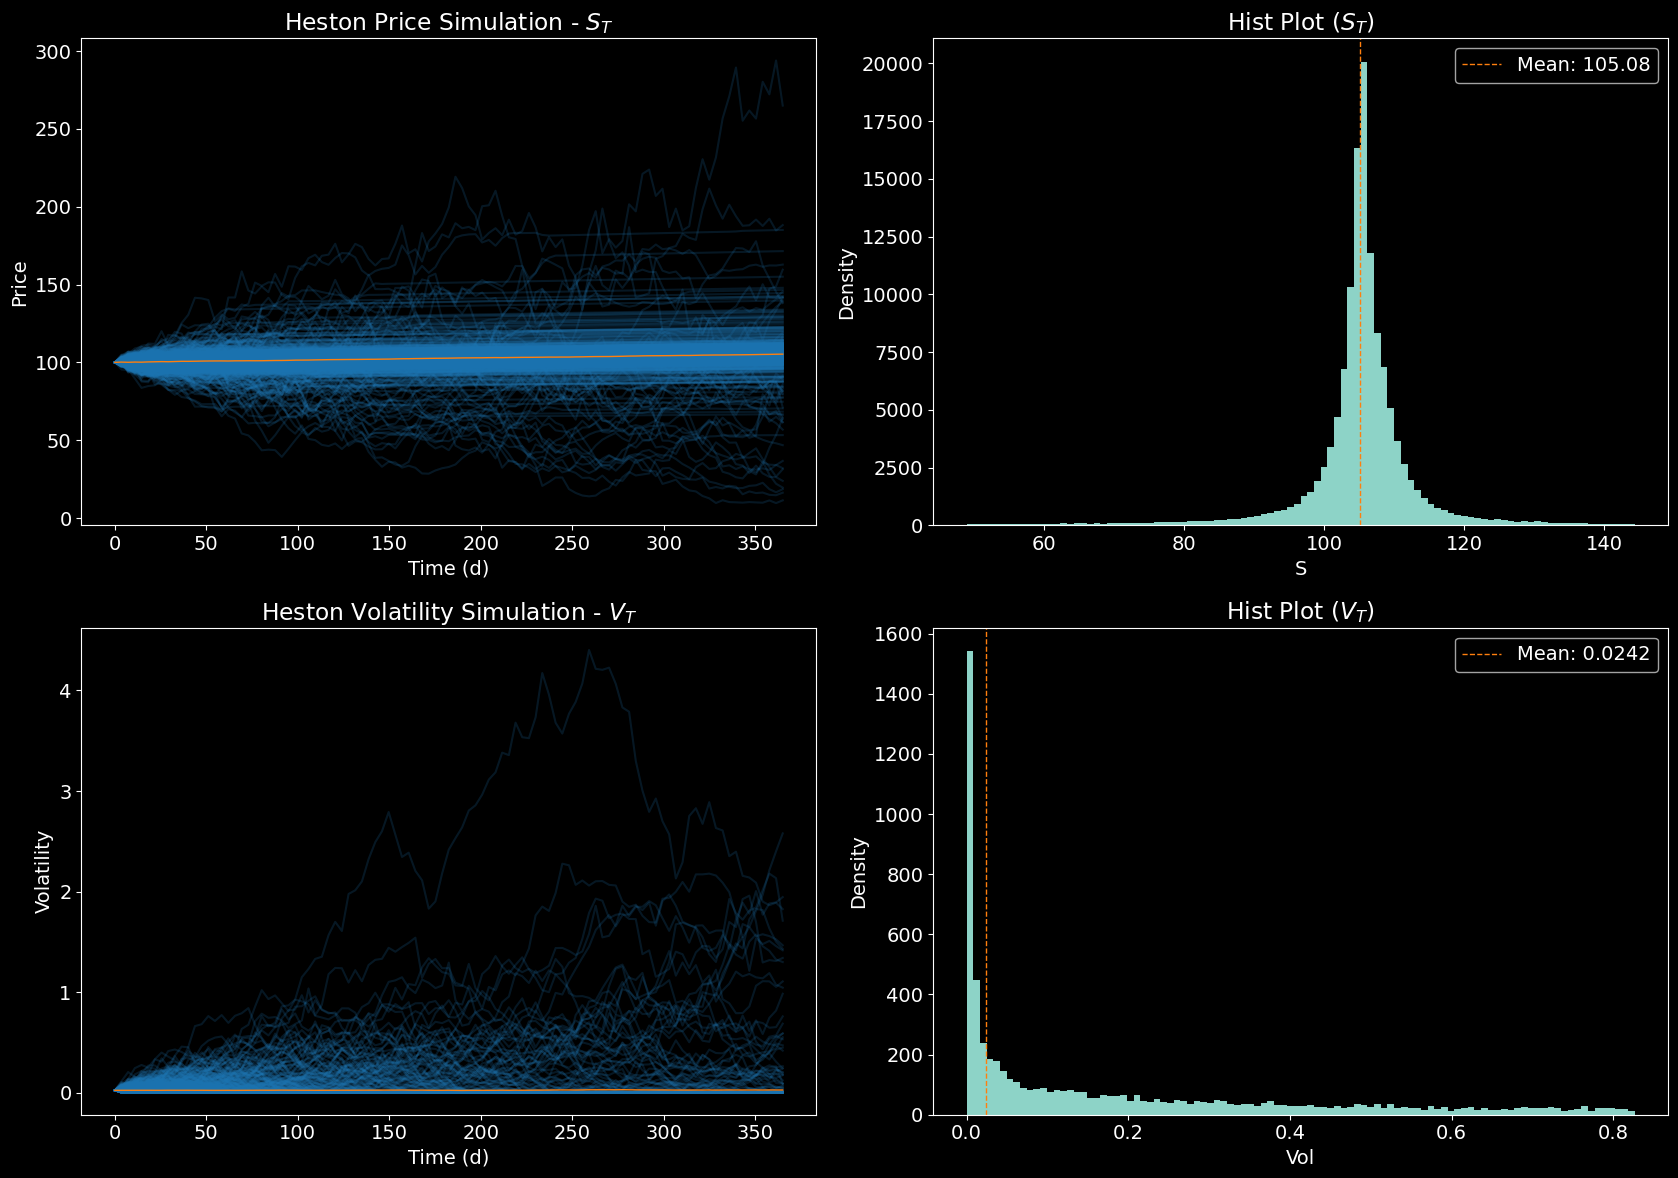

"N Paths: 131,072",Analytical,Empirical,95% CI,Difference
Moments,,,,
E[v_T],0.023847,0.024155,0.000650,-0.000309
E[v_T^2],0.030383,0.030807,0.001723,-0.000425
Std[v_T],0.172668,0.173850,0.004777,-0.001183
E[v_T^3],0.062238,0.059288,0.006248,0.002950
E[v_T^4],0.161257,0.147968,0.026247,0.013289


In [31]:
S0      = 100  # initial stock price 
r       = 0.05
q       = 0.00  # risk-free rate and dividend yield
v0      = 0.0228  # initial variance
theta   = 0.0363  # long-term mean variance
kappa   = 0.0807  # rate of mean reversion
sigma   = 1.1760  # volatility of variance
rho     = -0.3021   # correlation between stock and variance
N_paths = 100_000  ;    N_paths = int(2 ** np.ceil(np.log2(N_paths)))   # number of paths
T_steps = 100  # time horizon
T       = 1  # time horizon
dt      = 1/T_steps  # time step

print(f'Time step: {dt:.4f}, Time Horizon: {T} years with {int(2 ** np.ceil(np.log2(N_paths)))} paths and {T_steps} steps')
m1_vol_An, m2_vol_An, m3_vol_An, m4_vol_An, Var_vol_An = moments_CIR(kappa=kappa, theta=theta, sigma=sigma, v0=v0, T=T)


S_T_array_QE, v_T_array_QE = QESim(S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=dt,
                     T_steps=T_steps, N_paths=N_paths, Martingale_Correction=True)

# Test for if the moments of the vol mattch the theoretical values
m1_vol_Em   = v_T_array_QE[:,-1].mean()
m1_vol_SE   = v_T_array_QE[:,-1].reshape(128,-1).mean(axis=1).std() / sqrt(128)

m2_vol_Em   = ((v_T_array_QE[:,-1])**2).mean()
m2_vol_SE   = ((v_T_array_QE[:,-1])**2).reshape(128,-1).mean(axis=1).std() / sqrt(128)

Std_vol_Em  = v_T_array_QE[:,-1].std()
Std_vol_SE  = v_T_array_QE[:,-1].reshape(128,-1).std(axis=1).std() / sqrt(128)
Std_vol_An = np.sqrt(Var_vol_An)

m3_vol_Em   = ((v_T_array_QE[:,-1])**3).mean()
m3_vol_SE   = ((v_T_array_QE[:,-1])**3).reshape(128,-1).mean(axis=1).std() / sqrt(128)

m4_vol_Em   = ((v_T_array_QE[:,-1])**4).mean()
m4_vol_SE   = ((v_T_array_QE[:,-1])**4).reshape(128,-1).mean(axis=1).std() / sqrt(128)

# Creating the DataFrame
data = {
    'Analytical'    : [m1_vol_An, m2_vol_An, Std_vol_An, m3_vol_An, m4_vol_An],
    'Empirical'     : [m1_vol_Em, m2_vol_Em, Std_vol_Em, m3_vol_Em, m4_vol_Em],
    '95% CI'        : [1.96 * m1_vol_SE, 1.96 * m2_vol_SE, 1.96 * Std_vol_SE, 1.96 * m3_vol_SE, 1.96 * m4_vol_SE],
    'Difference'    : [m1_vol_An - m1_vol_Em, m2_vol_An - m2_vol_Em, Std_vol_An - Std_vol_Em, m3_vol_An - m3_vol_Em, m4_vol_An - m4_vol_Em],
}
index = ['E[v_T]', 'E[v_T^2]', 'Std[v_T]', 'E[v_T^3]', 'E[v_T^4]']
Moments_QE_df = pd.DataFrame(data, index=index)
Moments_QE_df.index.name = 'Moments'
Moments_QE_df.columns.name = f'N Paths: {N_paths:,}'


# visualize a_price and vol
bins = 100
fig, axs = plt.subplots(2, 2, figsize=(17, 12), tight_layout=True)
df_S = pd.DataFrame(S_T_array_QE[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_S.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[0,0])
df_S.mean(axis=1).plot(ax=axs[0,0], color='tab:orange', alpha=1, linewidth=1)
axs[0,0].set(xlabel='Time (d)', ylabel='Price', title=r'Heston Price Simulation - $S_T$')

df_vol = pd.DataFrame(v_T_array_QE[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_vol.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[1,0])
df_vol.mean(axis=1).plot(ax=axs[1,0], color='tab:orange', alpha=1, linewidth=1)
axs[1,0].set(xlabel='Time (d)', ylabel='Volatility', title=r'Heston Volatility Simulation - $V_T$')

# get the a_price which are within the 99 quantiles
_S_T_array_QE   = S_T_array_QE[(S_T_array_QE[:,-1] < np.quantile(S_T_array_QE[:,-1], 0.99)) & (S_T_array_QE[:,-1] > np.quantile(S_T_array_QE[:,-1], 0.01))]
_v_T_array_QE   = v_T_array_QE[(v_T_array_QE[:,-1] < np.quantile(v_T_array_QE[:,-1], 0.99)) & (v_T_array_QE[:,-1] > np.quantile(v_T_array_QE[:,-1], 0.01))]
axs[0,1].hist(_S_T_array_QE[:,-1], bins=bins)  
axs[0,1].axvline(S_T_array_QE[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {S_T_array_QE[:,-1].mean():.2f}')
axs[0,1].set(xlabel='S', ylabel='Density', title=r'Hist Plot ($S_T$)')
axs[0,1].legend()
axs[1,1].hist(_v_T_array_QE[:,-1], bins=bins) 
axs[1,1].axvline(v_T_array_QE[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {v_T_array_QE[:,-1].mean():.4f}')
axs[1,1].set(xlabel='Vol', ylabel='Density', title=r'Hist Plot ($V_T$)')
axs[1,1].legend()
plt.show()

Moments_QE_df.to_csv('Moments: QE Heston.csv', float_format='%.6f')
Moments_QE_df

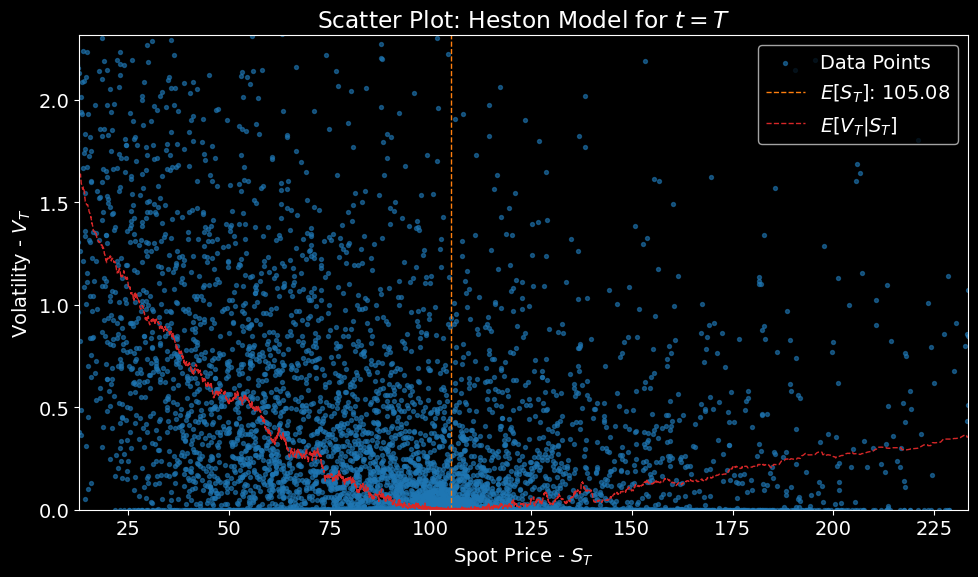

In [32]:
x_left_lim, x_right_lim = np.quantile(S_T_array_QE[:,-1], 0.001), np.quantile(S_T_array_QE[:,-1], 0.999)
y_upper_lim, y_lower_lim = np.quantile(v_T_array_QE[:,-1], 0.999), np.quantile(v_T_array_QE[:,-1], 0.001)   
unique_S_T = np.unique(S_T_array_QE[:, -1])

knn = KNeighborsRegressor(n_neighbors=200, n_jobs=-1)
knn.fit(S_T_array_QE[:, [-1]], v_T_array_QE[:,-1])
vol_pred = knn.predict(unique_S_T.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.scatter(S_T_array_QE[:100_000,-1], v_T_array_QE[:100_000,-1], alpha=0.6, color='tab:blue', label='Data Points', s=8)
plt.axvline(S_T_array_QE[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=r'$E[S_T]$: '+f'{S_T_array_QE[:,-1].mean():.2f}')
plt.plot(unique_S_T, vol_pred, label=r'$E[V_T|S_T]$', linestyle='dashed', linewidth=1, color='tab:red')
plt.xlim(x_left_lim, x_right_lim)
plt.ylim(y_lower_lim, y_upper_lim)
plt.xlabel(r'Spot Price - $S_T$')
plt.ylabel(r'Volatility - $V_T$')
plt.title(r'Scatter Plot: Heston Model for $t=T$')
plt.legend() ; plt.tight_layout() 
plt.show()

# Simulate the Heston model with Euler-Maruyama method
The Euler-Maruyama method is used to simulate the Heston Stochastic Volatility Model. The model equations are:

\begin{align*}
  \tilde{V}_t &= V_{t-1} + \kappa (\theta - V_{t-1}) \Delta t + \sigma \sqrt{V_{t-1}} dW^S_t \\
  V_t &= \max \left\{ \tilde{V}[t, :], 0 \right\} \\
  X_t &= X_{t-1} + \left(r - \frac{1}{2}V_{t-1}\right) \Delta t + \sqrt{V_{t-1}} dW^v_t \\
\end{align*}

Where:
$$
dW^S_t dW^v_t = \rho dt
$$


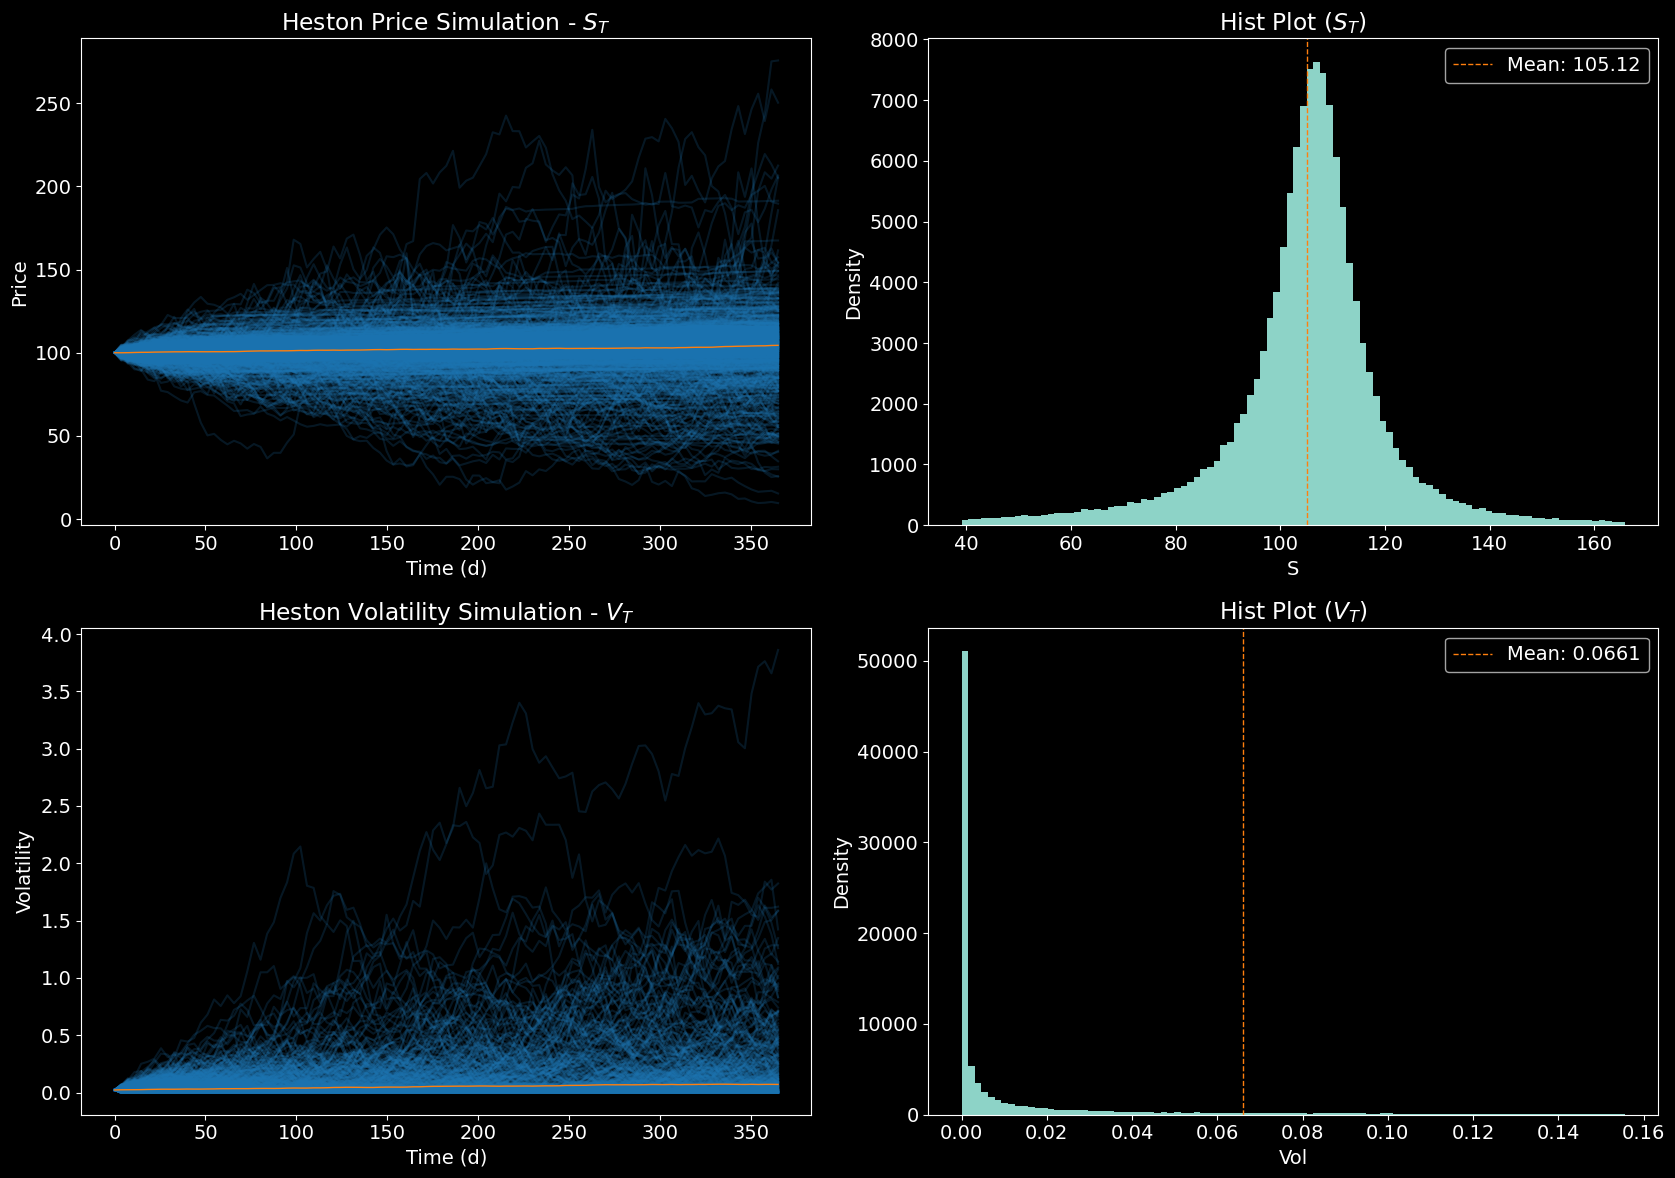

"N Paths: 131,072",Analytical,Empirical,95% CI,Difference
Moments,,,,
E[v_T],0.023847,0.066101,0.001198,-0.042254
E[v_T^2],0.030383,0.057195,0.002376,-0.026812
Std[v_T],0.172668,0.229837,0.004750,-0.057170
E[v_T^3],0.062238,0.091538,0.007637,-0.029299
E[v_T^4],0.161257,0.206810,0.030144,-0.045553


In [33]:
def sim_heston_simple(S0, V0, rho, theta, sigma, kappa, r, q, dt, T_steps, N_paths):
    # Pre-allocate arrays for stock prices and variances
    X_paths = np.zeros((T_steps + 1, N_paths))
    V_paths = np.zeros((T_steps + 1, N_paths))

    # Initial values
    X_paths[0, :] = log(S0)
    V_paths[0, :] = V0

    # Generate random numbers for the Brownian motions
    Z1 = np.random.normal(size=(T_steps, N_paths))
    Z2 = np.random.normal(size=(T_steps, N_paths))
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Z2

    for t in range(1, T_steps + 1):
        # Ensure non-negativity of variance
        V_paths[t, :] = np.maximum(V_paths[t - 1, :] + kappa * (theta - V_paths[t - 1, :]) * dt + sigma * np.sqrt(V_paths[t - 1, :] * dt) * W2[t - 1, :], 0)
        
        # Calculate stock prices
        X_paths[t, :] = X_paths[t - 1, :] + ((r - q - 0.5 * V_paths[t - 1, :]) * dt + np.sqrt(V_paths[t - 1, :] * dt) * W1[t - 1, :])

    return exp(X_paths).T, V_paths.T

S_T_array_EM, v_T_array_EM = sim_heston_simple(S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=dt, T_steps=T_steps, N_paths=N_paths)

m1_vol_An, m2_vol_An, m3_vol_An, m4_vol_An, Var_vol_An = moments_CIR(kappa=kappa, theta=theta, sigma=sigma, v0=v0, T=T)

# Test for if the moments of the vol mattch the theoretical values
m1_vol_Em   = v_T_array_EM[:,-1].mean()
m1_vol_SE   = v_T_array_EM[:,-1].reshape(128,-1).mean(axis=1).std() / sqrt(128)

m2_vol_Em   = ((v_T_array_EM[:,-1])**2).mean()
m2_vol_SE   = ((v_T_array_EM[:,-1])**2).reshape(128,-1).mean(axis=1).std() / sqrt(128)

Std_vol_Em  = v_T_array_EM[:,-1].std()
Std_vol_SE  = v_T_array_EM[:,-1].reshape(128,-1).std(axis=1).std() / sqrt(128)

m3_vol_Em   = ((v_T_array_EM[:,-1])**3).mean()
m3_vol_SE   = ((v_T_array_EM[:,-1])**3).reshape(128,-1).mean(axis=1).std() / sqrt(128)

m4_vol_Em   = ((v_T_array_EM[:,-1])**4).mean()
m4_vol_SE   = ((v_T_array_EM[:,-1])**4).reshape(128,-1).mean(axis=1).std() / sqrt(128)

# Creating the DataFrame
data = {
    'Analytical': [m1_vol_An, m2_vol_An, Std_vol_An, m3_vol_An, m4_vol_An],
    'Empirical': [m1_vol_Em, m2_vol_Em, Std_vol_Em, m3_vol_Em, m4_vol_Em],
    '95% CI': [1.96 * m1_vol_SE, 1.96 * m2_vol_SE, 1.96 * Std_vol_SE, 1.96 * m3_vol_SE, 1.96 * m4_vol_SE],
    'Difference': [m1_vol_An - m1_vol_Em, m2_vol_An - m2_vol_Em, Std_vol_An - Std_vol_Em, m3_vol_An - m3_vol_Em, m4_vol_An - m4_vol_Em],
}
Moments_simple_df = pd.DataFrame(data, index=index)
Moments_simple_df.columns.name = f'N Paths: {N_paths:,}'
Moments_simple_df.index.name = 'Moments'


# visualize a_price and vol
bins = 100
fig, axs = plt.subplots(2, 2, figsize=(17, 12), tight_layout=True)
df_S = pd.DataFrame(S_T_array_EM[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_S.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[0,0])
df_S.mean(axis=1).plot(ax=axs[0,0], color='tab:orange', alpha=1, linewidth=1)
axs[0,0].set(xlabel='Time (d)', ylabel='Price', title=r'Heston Price Simulation - $S_T$')

df_vol = pd.DataFrame(v_T_array_EM[:1000]).T.set_index(np.linspace(0, T*365, T_steps+1))
df_vol.plot(legend=False, color='tab:blue', alpha=0.2, ax=axs[1,0])
df_vol.mean(axis=1).plot(ax=axs[1,0], color='tab:orange', alpha=1, linewidth=1)
axs[1,0].set(xlabel='Time (d)', ylabel='Volatility', title=r'Heston Volatility Simulation - $V_T$')

# get the a_price which are within the 99 quantiles
_a_price = S_T_array_EM[(S_T_array_EM[:,-1] < np.quantile(S_T_array_EM[:,-1], 0.99)) & (S_T_array_EM[:,-1] > np.quantile(S_T_array_EM[:,-1], 0.01))]
_vol     = v_T_array_EM[(v_T_array_EM[:,-1] < np.quantile(v_T_array_EM[:,-1], 0.90)) & (v_T_array_EM[:,-1] > np.quantile(v_T_array_EM[:,-1], 0.01))]
axs[0,1].hist(_a_price[:,-1], bins=bins)  
axs[0,1].axvline(S_T_array_EM[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {S_T_array_EM[:,-1].mean():.2f}')
axs[0,1].set(xlabel='S', ylabel='Density', title=r'Hist Plot ($S_T$)')
axs[0,1].legend()
axs[1,1].hist(_vol[:,-1], bins=bins)
axs[1,1].axvline(v_T_array_EM[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=f'Mean: {v_T_array_EM[:,-1].mean():.4f}')
axs[1,1].set(xlabel='Vol', ylabel='Density', title=r'Hist Plot ($V_T$)')
axs[1,1].legend()
plt.show()

Moments_simple_df.to_csv('Moments: Simple Heston.csv', float_format='%.6f')
Moments_simple_df

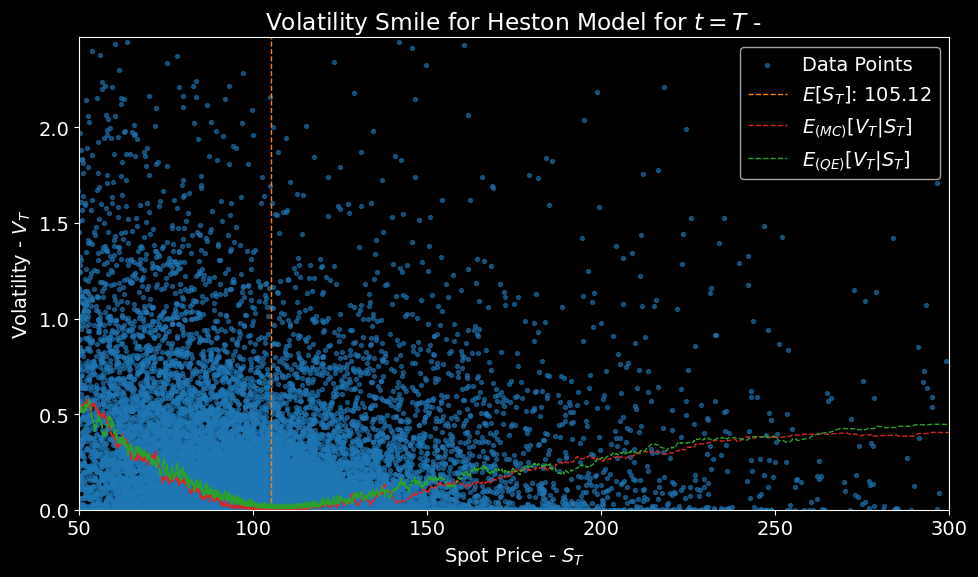

In [34]:
x_left_lim, x_right_lim = np.quantile(S_T_array_EM[:,-1], 0.001), np.quantile(S_T_array_EM[:,-1], 0.999)
y_upper_lim, y_lower_lim = np.quantile(v_T_array_EM[:,-1], 0.999), np.quantile(v_T_array_EM[:,-1], 0.001)   
unique_S_T = np.unique(S_T_array_EM[:, -1])

knn2 = KNeighborsRegressor(n_neighbors=200, n_jobs=-1)
knn2.fit(S_T_array_EM[:, -1].reshape(-1, 1), v_T_array_EM[:,-1])
vol_pred  = knn.predict(unique_S_T.reshape(-1, 1))
vol_pred2 = knn2.predict(unique_S_T.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.scatter(S_T_array_EM[:100_000,-1], v_T_array_EM[:100_000,-1], alpha=0.6, color='tab:blue', label='Data Points', s=8)
plt.axvline(S_T_array_EM[:,-1].mean(), color='tab:orange', linestyle='dashed', linewidth=1, label=r'$E[S_T]$: '+f'{S_T_array_EM[:,-1].mean():.2f}')
plt.plot(unique_S_T, vol_pred, label=r'$E_{(MC)}[V_T|S_T]$', linestyle='dashed', linewidth=1, color='tab:red')
plt.plot(unique_S_T, vol_pred2, label=r'$E_{(QE)}[V_T|S_T]$ ', linestyle='dashed', linewidth=1, color='tab:green')
plt.xlim(50, 300)
plt.ylim(y_lower_lim, y_upper_lim)
plt.xlabel(r'Spot Price - $S_T$')
plt.ylabel(r'Volatility - $V_T$')
plt.title(r'Volatility Smile for Heston Model for $t=T$ - ')
plt.legend() ; plt.tight_layout() 
plt.show()

-------------------------------------------------------
# Plot Implied volatility surface of Heston model

In [35]:
from scipy.integrate import quad
from functools import partial

def Heston_FFT(S0, K, T, r, kappa, theta, sigma, v0, rho, opt_type):
    def Q1(k, cf, right_lim):
        """
        P(X<k) - Probability to be in the money under the stock numeraire.
        cf: characteristic function
        right_lim: right limit of integration
        """

        def integrand(u):
            return np.real((np.exp(-u * k * 1j) / (u * 1j)) * cf(u - 1j) / cf(-1.0000000000001j))

        return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]


    def Q2(k, cf, right_lim):
        """
        P(X<k) - Probability to be in the money under the money market numeraire
        cf: characteristic function
        right_lim: right limit of integration
        """

        def integrand(u):
            return np.real(np.exp(-u * k * 1j) / (u * 1j) * cf(u))

        return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=2000)[0]

    def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
        """
        Heston characteristic function as proposed by Schoutens (2004)
        """
        xi = kappa - sigma * rho * u * 1j
        d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
        g1 = (xi + d) / (xi - d)
        g2 = 1 / g1
        cf = np.exp(
            1j * u * mu * t
            + (kappa * theta) / (sigma**2) * ((xi - d) * t - 2 * np.log((1 - g2 * np.exp(-d * t)) / (1 - g2)))
            + (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * t)) / (1 - g2 * np.exp(-d * t))
        )
        return cf

    cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho)

    k = np.log(K / S0)  # log moneyness
    limit_max = 1000  # right limit in the integration
    call = S0 * Q1(k, cf_H_b_good, limit_max) - K * np.exp(-r * T) * Q2(k, cf_H_b_good, limit_max)

    return call if opt_type == 'c' else call + K * np.exp(-r * T) - S0

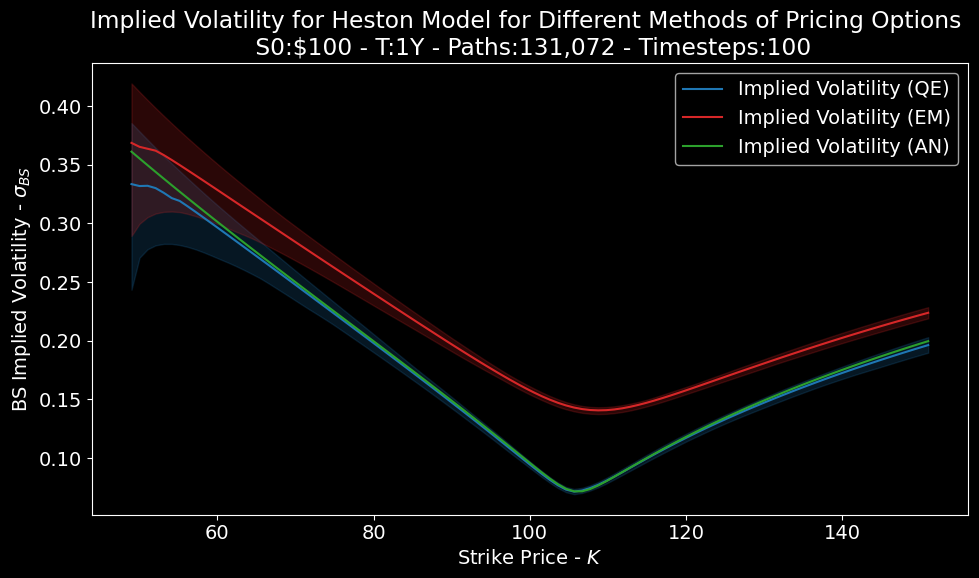

In [36]:
import py_vollib_vectorized

K_array = np.linspace(49, 151, 100)
def Bootstrap_IV(S_T_array):
    np.random.seed(42)
    n = 1_00
    idxs = np.random.choice(S_T_array.shape[0], (n, 30_000), replace=1)

    IV_B = []
    for idx in tqdm(idxs, leave=False):
        S_T = S_T_array[idx]
        _C0 = np.array([np.exp(-r * T) * np.maximum(S_T - K, 0).mean() for K in K_array])
        _ivs = py_vollib_vectorized.vectorized_implied_volatility(
                price=_C0, S=S0, K=K_array, t=T, r=r, flag='c', q=q, on_error='ignore', model='black_scholes_merton',return_as='numpy') 
        
        IV_B.append(_ivs)
    IV_B = np.array(IV_B)        

    IV_mean = IV_B.mean(axis=0)
    IV_5, IV_95 = np.percentile(IV_B, [5, 95], axis=0)
    IV_SE   = 1.96 * IV_B.std(axis=0) #/ np.sqrt(n)

    return IV_mean, IV_SE, IV_5, IV_95


IV_mean_EM, IV_SE_EM, IV_5_EM, IV_95_EM = Bootstrap_IV(S_T_array_EM[:,-1])
IV_mean_QE, IV_SE_QE, IV_5_QE, IV_95_QE = Bootstrap_IV(S_T_array_QE[:,-1])

C0_FFT = [Heston_FFT(S0=S0, K=K, T=T, r=r, kappa=kappa, theta=theta, rho=rho, sigma=sigma, v0=v0, opt_type='c') for K in K_array]
iv_array_FFT = py_vollib_vectorized.vectorized_implied_volatility(
    price=C0_FFT, S=S0, K=K_array, t=T, r=r, flag='c', q=q, on_error='ignore', model='black_scholes_merton',return_as='numpy')

C0_QE = np.array([np.exp(-r * T) * np.maximum(S_T_array_QE[:,-1] - K, 0).mean() for K in K_array])
iv_array_QE = py_vollib_vectorized.vectorized_implied_volatility(
    price=C0_QE, S=S0, K=K_array, t=T, r=r, flag='c', q=q, on_error='ignore', model='black_scholes_merton',return_as='numpy')

plt.figure(figsize=(10, 6))
plt.plot(K_array, IV_mean_QE, label='Implied Volatility (QE)', color='tab:blue')
# plt.plot(K_array, iv_array_QE, label='Implied Volatility (QE2)', color='blue')
# plt.fill_between(K_array, IV_mean_QE - IV_SE_QE, IV_mean_QE + IV_SE_QE, alpha=0.2, color='tab:blue')
plt.fill_between(K_array, IV_5_QE, IV_95_QE, alpha=0.2, color='tab:blue')

plt.plot(K_array, IV_mean_EM, label='Implied Volatility (EM)', color='tab:red')
# plt.fill_between(K_array, IV_mean_EM - IV_SE_EM, IV_mean_EM + IV_SE_EM, alpha=0.2, color='tab:red')
plt.fill_between(K_array, IV_5_EM, IV_95_EM, alpha=0.2, color='tab:red')

plt.plot(K_array, iv_array_FFT, label='Implied Volatility (AN)', color='tab:green')
plt.xlabel(r'Strike Price - $K$') ; plt.ylabel(r'BS Implied Volatility - $\sigma_{BS}$')
plt.title(f'Implied Volatility for Heston Model for Different Methods of Pricing Options \n S0:${S0} - T:{T}Y - Paths:{N_paths:,} - Timesteps:{T_steps:,}')
plt.legend() ; plt.tight_layout() ; plt.show()

In [37]:
# Assuming Moments_simple_df and Moments_QE_df are already defined
combined_df = pd.concat([Moments_simple_df.add_prefix('(EM)'), Moments_QE_df.add_prefix('(QE)')], axis=1)
combined_df.rename(columns={'(EM)Analytical': 'Analytical'}, inplace=True)
# Reorder columns
combined_df = combined_df[['Analytical', '(EM)Empirical', '(EM)95% CI', '(EM)Difference', '(QE)Empirical', '(QE)95% CI', '(QE)Difference']]
combined_df.index.name = 'Moments'
combined_df.columns.name = f'N: {N_paths:,}, T: {T_steps}'
combined_df.to_csv('QE vs Euler V_t moments.csv', float_format='%.6f')
combined_df

"N: 131,072, T: 100",Analytical,(EM)Empirical,(EM)95% CI,(EM)Difference,(QE)Empirical,(QE)95% CI,(QE)Difference
Moments,,,,,,,
E[v_T],0.023847,0.066101,0.001198,-0.042254,0.024155,0.000650,-0.000309
E[v_T^2],0.030383,0.057195,0.002376,-0.026812,0.030807,0.001723,-0.000425
Std[v_T],0.172668,0.229837,0.004750,-0.057170,0.173850,0.004777,-0.001183
E[v_T^3],0.062238,0.091538,0.007637,-0.029299,0.059288,0.006248,0.002950
E[v_T^4],0.161257,0.206810,0.030144,-0.045553,0.147968,0.026247,0.013289


-------------------------------------------------------
# Difference in moments as a function of N_pants and T_steps

In [89]:
# print(stop)
def get_difference_in_moments(method, N_paths, T_steps):
    dt      = 1/T_steps 
    S_T_array, v_T_array = method(S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=dt, T_steps=T_steps, N_paths=N_paths)
    m1_vol_An, m2_vol_An, m3_vol_An, m4_vol_An, Var_vol_An = moments_CIR(kappa=kappa, theta=theta, sigma=sigma, v0=v0, T=T)
    Std_vol_An = np.sqrt(Var_vol_An)
    # Test for if the moments of the vol mattch the theoretical values
    m1_vol_Em   = v_T_array[:,-1].mean()
    m1_vol_SE   = v_T_array[:,-1].reshape(128,-1).mean(axis=1).std() / sqrt(128)

    m2_vol_Em   = ((v_T_array[:,-1])**2).mean()
    m2_vol_SE   = ((v_T_array[:,-1])**2).reshape(128,-1).mean(axis=1).std() / sqrt(128)

    Std_vol_Em  = v_T_array[:,-1].std()
    Std_vol_SE  = v_T_array[:,-1].reshape(128,-1).std(axis=1).std() / sqrt(128)

    m3_vol_Em   = ((v_T_array[:,-1])**3).mean()
    m3_vol_SE   = ((v_T_array[:,-1])**3).reshape(128,-1).mean(axis=1).std() / sqrt(128)

    m4_vol_Em   = ((v_T_array[:,-1])**4).mean()
    m4_vol_SE   = ((v_T_array[:,-1])**4).reshape(128,-1).mean(axis=1).std() / sqrt(128)

    return m1_vol_An - m1_vol_Em, m2_vol_An - m2_vol_Em, Std_vol_An - Std_vol_Em, m3_vol_An - m3_vol_Em, m4_vol_An - m4_vol_Em


-------------------------------------------------------
# Moments Analysis as a Function of the Number of Timesteps

In [120]:
import gc

# N_paths = 2**14 # 16384
n_bootstrap_samples = 128
N_paths = int(2**20 / n_bootstrap_samples)# 131072
T_steps_array = [1, 2, 4, 12, 52, 100, 365]

_diffs_QE_Timesteps = []
_diffs_EM_Timesteps = []


for t_steps in (T_steps_array):
    print(f'Running for {t_steps} steps ===========================', end='\n')
    _diffs_QE_Timesteps.append(
        np.array([ (get_difference_in_moments(QESim, N_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
    )
    _diffs_EM_Timesteps.append(
        np.array([ (get_difference_in_moments(sim_heston_simple, N_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
    )
    gc.collect()

_diffs_QE_Timesteps = np.array(_diffs_QE_Timesteps)
_diffs_EM_Timesteps = np.array(_diffs_EM_Timesteps)

Running for 1 steps ===========================


Running for 2 steps ===========================


Running for 4 steps ===========================


Running for 12 steps ===========================


Running for 52 steps ===========================


Running for 100 steps ===========================


Running for 365 steps ===========================


Simulating Paths:  60%|█████▉    | 218/365 [00:00<00:00, 2177.43it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_33550/1733457018.py:106: RuntimeWarning: invalid value encountered in multiply
  S[t] = S[t - 1] + (r - q)*dt + K0      + K1*V[t - 1] + K2*V[t] + np.sqrt(K3*V[t - 1] + K4*V[t])*Zs[t]


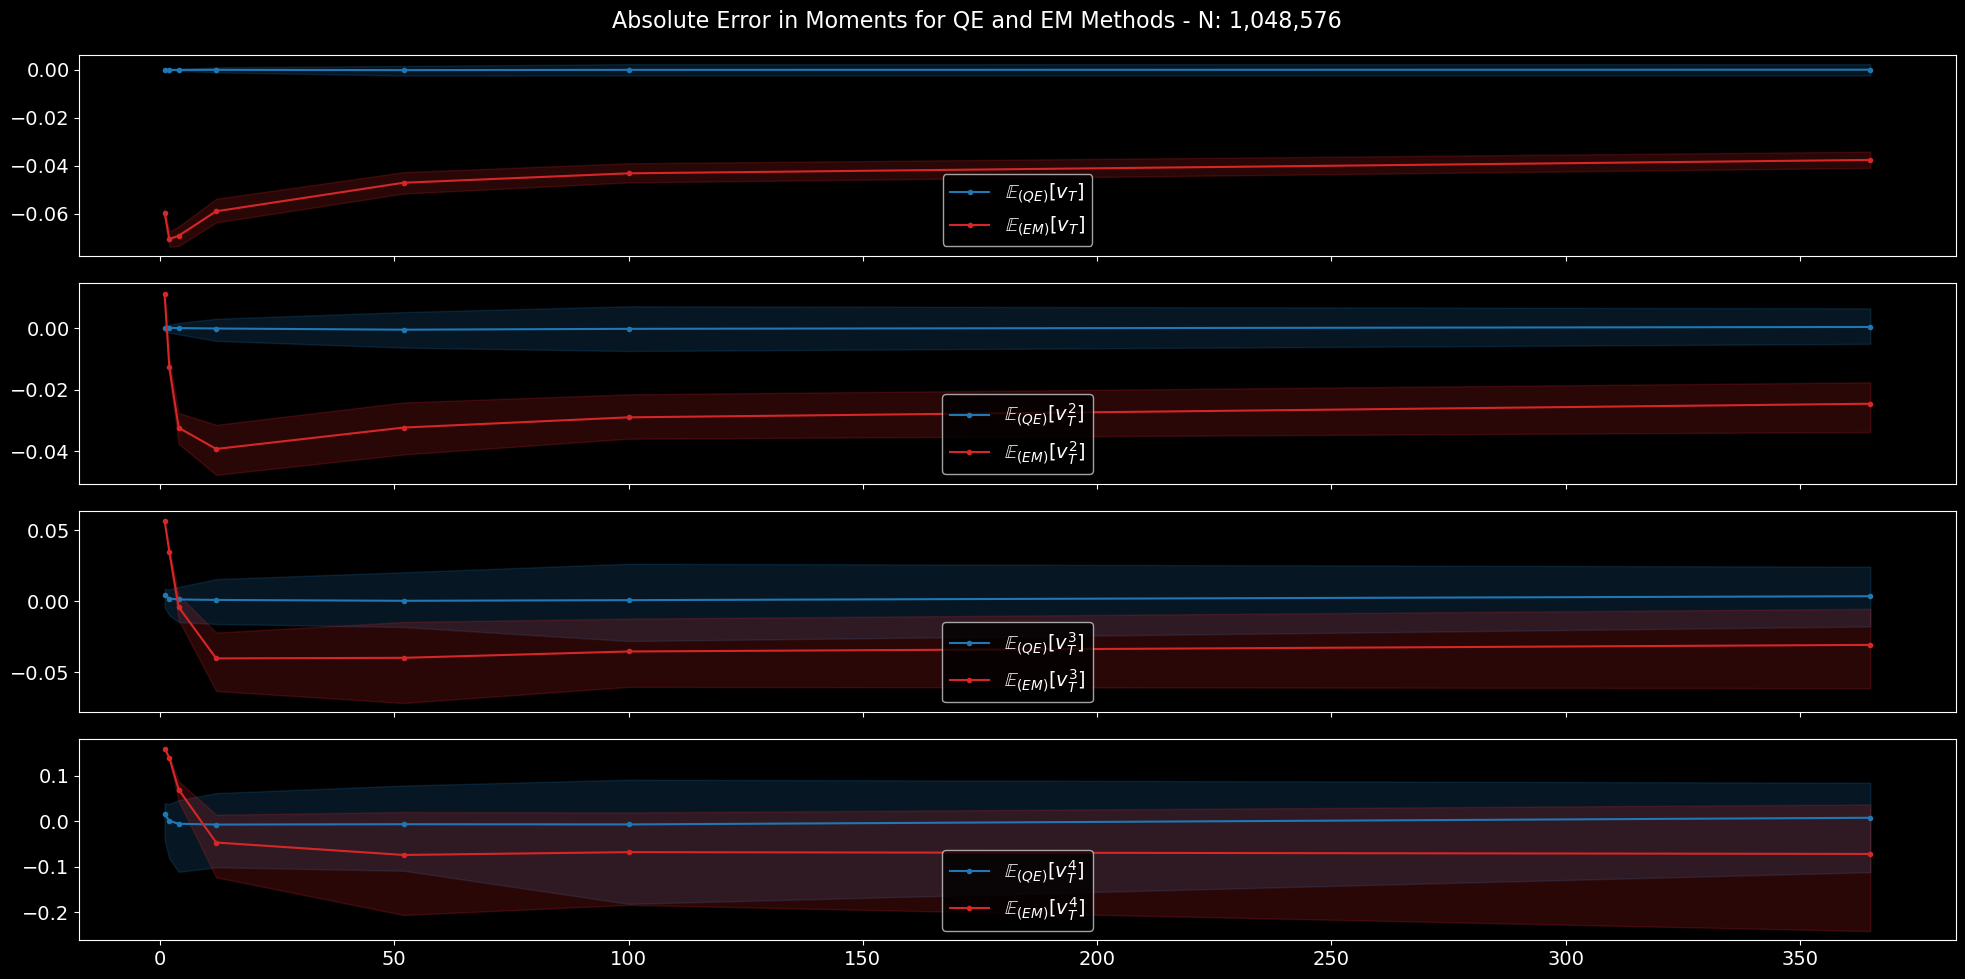

In [124]:
diffs_QE_Timesteps = _diffs_QE_Timesteps            ; diffs_EM_Timesteps = _diffs_EM_Timesteps
# diffs_QE_Timesteps = np.abs(_diffs_QE_Timesteps)    ; diffs_EM_Timesteps = np.abs(_diffs_EM_Timesteps)

Means_QE_Timesteps = diffs_QE_Timesteps.mean(axis=(2))
Q5_QE, Q95_QE = np.percentile(diffs_QE_Timesteps, [5, 95], axis=(2))

Means_EM_Timesteps = diffs_EM_Timesteps.mean(axis=(2))
Q5_EM, Q95_EM = np.percentile(diffs_EM_Timesteps, [5, 95], axis=(2))

# plot the differences in moments and their 95% CI
fig, axs = plt.subplots(4, figsize=(20, 10), tight_layout=True, sharex=True)
axs[0].plot(T_steps_array, Means_QE_Timesteps[:,0], label=r'$\mathbb{E}_{(QE)}[v_T]$', color='tab:blue', marker='.')
axs[0].fill_between(T_steps_array, Q5_QE[:,0], Q95_QE[:,0], alpha=0.2, color='tab:blue')
axs[0].plot(T_steps_array, Means_EM_Timesteps[:,0], label=r'$\mathbb{E}_{(EM)}[v_T]$', color='tab:red', marker='.')
axs[0].fill_between(T_steps_array, Q5_EM[:,0], Q95_EM[:,0], alpha=0.2, color='tab:red')

# E[v_T^2]
axs[1].plot(T_steps_array, Means_QE_Timesteps[:,1], label=r'$\mathbb{E}_{(QE)}[v_T^2]$', color='tab:blue', marker='.')
axs[1].fill_between(T_steps_array, Q5_QE[:,1], Q95_QE[:,1], alpha=0.2, color='tab:blue')
axs[1].plot(T_steps_array, Means_EM_Timesteps[:,1], label=r'$\mathbb{E}_{(EM)}[v_T^2]$', color='tab:red', marker='.')
axs[1].fill_between(T_steps_array, Q5_EM[:,1], Q95_EM[:,1], alpha=0.2, color='tab:red')

# E[v_T^3]
axs[2].plot(T_steps_array, Means_QE_Timesteps[:,3], label=r'$\mathbb{E}_{(QE)}[v_T^3]$', color='tab:blue', marker='.')
axs[2].fill_between(T_steps_array, Q5_QE[:,3], Q95_QE[:,3], alpha=0.2, color='tab:blue')
axs[2].plot(T_steps_array, Means_EM_Timesteps[:,3], label=r'$\mathbb{E}_{(EM)}[v_T^3]$', color='tab:red', marker='.')
axs[2].fill_between(T_steps_array, Q5_EM[:,3], Q95_EM[:,3], alpha=0.2, color='tab:red')

# E[v_T^4]
axs[3].plot(T_steps_array, Means_QE_Timesteps[:,4], label=r'$\mathbb{E}_{(QE)}[v_T^4]$', color='tab:blue', marker='.')
axs[3].fill_between(T_steps_array, Q5_QE[:,4], Q95_QE[:,4], alpha=0.2, color='tab:blue')
axs[3].plot(T_steps_array, Means_EM_Timesteps[:,4], label=r'$\mathbb{E}_{(EM)}[v_T^4]$', color='tab:red', marker='.')
axs[3].fill_between(T_steps_array, Q5_EM[:,4], Q95_EM[:,4], alpha=0.2, color='tab:red')

axs[0].legend(loc='lower center') ; axs[1].legend(loc='lower center') ; axs[2].legend(loc='lower center') ; axs[3].legend(loc='lower center')
fig.suptitle(f'Absolute Error in Moments for QE and EM Methods - N: {N_paths*n_bootstrap_samples:,}', fontsize=16)
# axs[0].set_yscale('log') ; axs[1].set_yscale('log') ; axs[2].set_yscale('log') ; axs[3].set_yscale('log')
plt.show()

In [125]:
E_v_df_1 = pd.concat([
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T](EM)']),
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^2](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^2](EM)']),
], axis=1)
E_v_df_1.index.name = 'T_steps'
E_v_df_1.columns.name = f'N: {N_paths*n_bootstrap_samples:,}'
E_v_df_1.to_csv('Table: Per Timesteps: E_v 1.csv', float_format='%.6f')
E_v_df_1

"N: 1,048,576",E[v_T](QE),E[v_T](EM),E[v_T^2](QE),E[v_T^2](EM)
T_steps,,,,
1,0.000004,-0.059612,0.000004,-0.059612
2,0.000002,-0.070621,0.000002,-0.070621
4,-0.000002,-0.069232,-0.000002,-0.069232
12,0.000023,-0.059014,0.000023,-0.059014
52,-0.000091,-0.047101,-0.000091,-0.047101
100,0.000020,-0.043175,0.000020,-0.043175
365,0.000082,-0.037586,0.000082,-0.037586


In [126]:
E_v_df_2 = pd.concat([
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^3](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^3](EM)']),
    pd.DataFrame(Means_QE_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^4](QE)']),
    pd.DataFrame(Means_EM_Timesteps[:,0], index=T_steps_array, columns=['E[v_T^4](EM)']),
], axis=1)
E_v_df_2.index.name = 'T_steps'
E_v_df_2.columns.name = f'N: {N_paths*n_bootstrap_samples:,}'
E_v_df_2.to_csv('Table: Per Timesteps: E_v 2.csv', float_format='%.6f')
E_v_df_2

"N: 1,048,576",E[v_T^3](QE),E[v_T^3](EM),E[v_T^4](QE),E[v_T^4](EM)
T_steps,,,,
1,0.000004,-0.059612,0.000004,-0.059612
2,0.000002,-0.070621,0.000002,-0.070621
4,-0.000002,-0.069232,-0.000002,-0.069232
12,0.000023,-0.059014,0.000023,-0.059014
52,-0.000091,-0.047101,-0.000091,-0.047101
100,0.000020,-0.043175,0.000020,-0.043175
365,0.000082,-0.037586,0.000082,-0.037586


-------------------------------------------------------
# Moments Analysis as a Function of the Number of Paths

In [109]:
import gc

n_bootstrap_samples = 128
N_paths_array = (2**np.arange(14, 21) / n_bootstrap_samples).astype(int)
t_steps = 100

_diffs_QE_Paths = []
_diffs_EM_Paths = []

for n_paths in (N_paths_array):
    print(f'Running for {n_paths*128} paths ===========================', end='\r')
    _diffs_QE_Paths.append(
        np.array([ (get_difference_in_moments(QESim, n_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
        # get_difference_in_moments(QESim, N_paths, t_steps)
    )
    _diffs_EM_Paths.append(
        np.array([ (get_difference_in_moments(sim_heston_simple, n_paths, t_steps)) for _ in range(n_bootstrap_samples)]).T
        # get_difference_in_moments(sim_heston_simple ,N_paths, t_steps)
    )
    gc.collect()

_diffs_QE_Paths = np.array(_diffs_QE_Paths)
_diffs_EM_Paths = np.array(_diffs_EM_Paths)

Simulating Paths:   0%|          | 0/100 [00:00<?, ?it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_33550/1733457018.py:84: RuntimeWarning: invalid value encountered in divide
  psi = s2 / m ** 2
/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_33550/1733457018.py:106: RuntimeWarning: invalid value encountered in add
  S[t] = S[t - 1] + (r - q)*dt + K0      + K1*V[t - 1] + K2*V[t] + np.sqrt(K3*V[t - 1] + K4*V[t])*Zs[t]


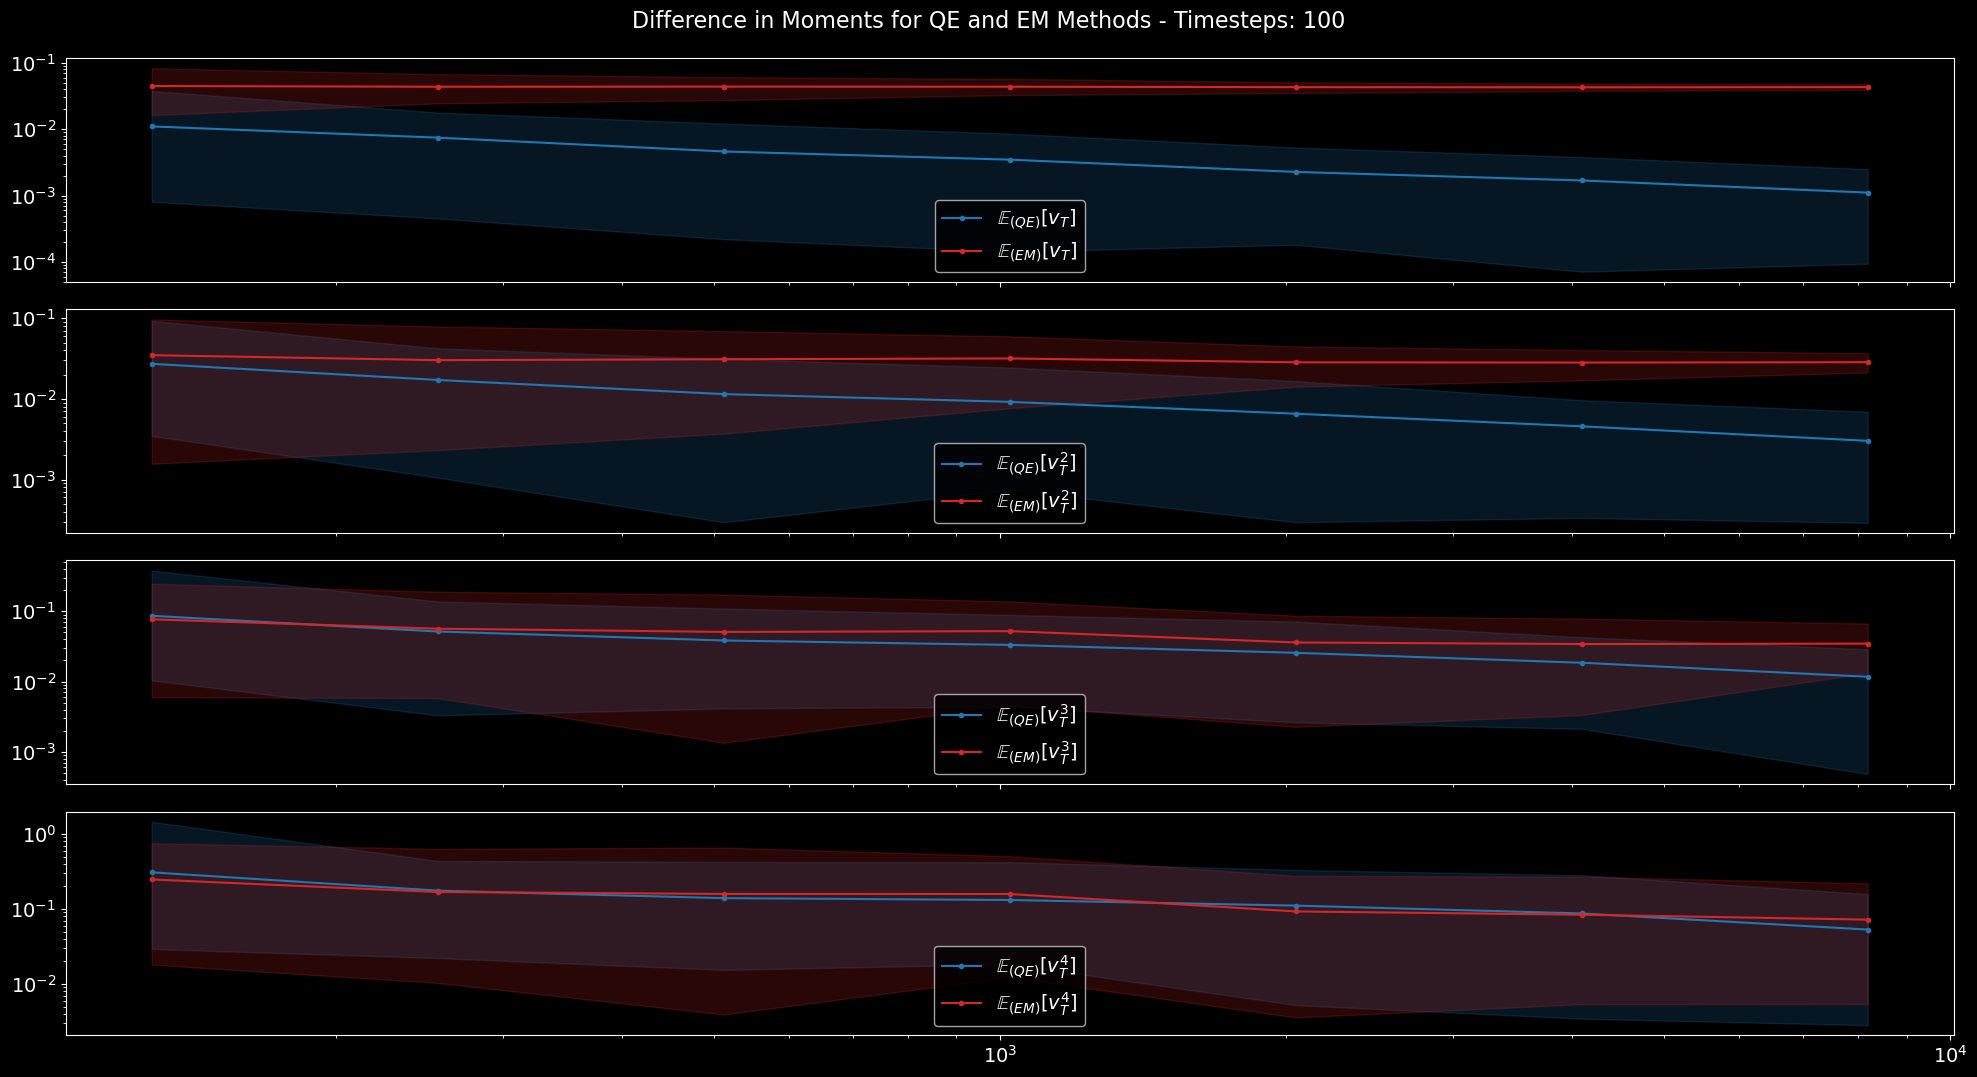

In [113]:
# plot diffs_QE
diffs_QE_Paths = _diffs_QE_Paths            ; diffs_EM_Paths = _diffs_EM_Paths
diffs_QE_Paths = np.abs(_diffs_QE_Paths)    ; diffs_EM_Paths = np.abs(_diffs_EM_Paths)

Means_QE_Paths = diffs_QE_Paths.mean(axis=(2))
Q5_QE, Q95_QE = np.percentile(diffs_QE_Paths, [5, 95], axis=(2))

Means_EM_Paths = diffs_EM_Paths.mean(axis=(2))
Q5_EM, Q95_EM = np.percentile(diffs_EM_Paths, [5, 95], axis=(2))

# plot the differences in moments and their 95% CI
fig, axs = plt.subplots(4, figsize=(20, 11), tight_layout=True, sharex=True)
axs[0].plot(N_paths_array, Means_QE_Paths[:,0], label=r'$\mathbb{E}_{(QE)}[v_T]$', color='tab:blue', marker='.')
axs[0].fill_between(N_paths_array, Q5_QE[:,0], Q95_QE[:,0], alpha=0.2, color='tab:blue')
axs[0].plot(N_paths_array, Means_EM_Paths[:,0], label=r'$\mathbb{E}_{(EM)}[v_T]$', color='tab:red', marker='.')
axs[0].fill_between(N_paths_array, Q5_EM[:,0], Q95_EM[:,0], alpha=0.2, color='tab:red')

# E[v_T^2]
axs[1].plot(N_paths_array, Means_QE_Paths[:,1], label=r'$\mathbb{E}_{(QE)}[v_T^2]$', color='tab:blue', marker='.')
axs[1].fill_between(N_paths_array, Q5_QE[:,1], Q95_QE[:,1], alpha=0.2, color='tab:blue')
axs[1].plot(N_paths_array, Means_EM_Paths[:,1], label=r'$\mathbb{E}_{(EM)}[v_T^2]$', color='tab:red', marker='.')
axs[1].fill_between(N_paths_array, Q5_EM[:,1], Q95_EM[:,1], alpha=0.2, color='tab:red')

# E[v_T^3]
axs[2].plot(N_paths_array, Means_QE_Paths[:,3], label=r'$\mathbb{E}_{(QE)}[v_T^3]$', color='tab:blue', marker='.')
axs[2].fill_between(N_paths_array, Q5_QE[:,3], Q95_QE[:,3], alpha=0.2, color='tab:blue')
axs[2].plot(N_paths_array, Means_EM_Paths[:,3], label=r'$\mathbb{E}_{(EM)}[v_T^3]$', color='tab:red', marker='.')
axs[2].fill_between(N_paths_array, Q5_EM[:,3], Q95_EM[:,3], alpha=0.2, color='tab:red')

# E[v_T^4]
axs[3].plot(N_paths_array, Means_QE_Paths[:,4], label=r'$\mathbb{E}_{(QE)}[v_T^4]$', color='tab:blue', marker='.')
axs[3].fill_between(N_paths_array, Q5_QE[:,4], Q95_QE[:,4], alpha=0.2, color='tab:blue')
axs[3].plot(N_paths_array, Means_EM_Paths[:,4], label=r'$\mathbb{E}_{(EM)}[v_T^4]$', color='tab:red', marker='.')
axs[3].fill_between(N_paths_array, Q5_EM[:,4], Q95_EM[:,4], alpha=0.2, color='tab:red')

axs[0].legend(loc='lower center') ; axs[1].legend(loc='lower center') ; axs[2].legend(loc='lower center') ; axs[3].legend(loc='lower center')
fig.suptitle(f'Difference in Moments for QE and EM Methods - Timesteps: {t_steps:,}', fontsize=16)
axs[0].set_yscale('log') ; axs[1].set_yscale('log') ; axs[2].set_yscale('log') ; axs[3].set_yscale('log')
plt.xscale('log')
plt.show()

In [114]:
E_v_df_11 = pd.concat([
    pd.DataFrame(Means_QE_Paths[:,0], index=N_paths_array*128, columns=['E[v_T](QE)']),
    pd.DataFrame(Means_EM_Paths[:,0], index=N_paths_array*128, columns=['E[v_T](EM)']),
    pd.DataFrame(Means_QE_Paths[:,1], index=N_paths_array*128, columns=['E[v_T^2](QE)']),
    pd.DataFrame(Means_EM_Paths[:,1], index=N_paths_array*128, columns=['E[v_T^2](EM)']),
], axis=1)
E_v_df_11.index.name = 'N paths'
E_v_df_11.columns.name = f'T steps: {t_steps:,}'
E_v_df_11.to_csv('Table: Per Paths: E_v 1.csv', float_format='%.6f')
E_v_df_11

T steps: 100,E[v_T](QE),E[v_T](EM),E[v_T^2](QE),E[v_T^2](EM)
N paths,,,,
16384,0.010998,0.044648,0.027261,0.034894
32768,0.007454,0.043577,0.017197,0.030280
65536,0.004613,0.043744,0.011490,0.031078
131072,0.003471,0.043628,0.009207,0.031791
262144,0.002268,0.042910,0.006562,0.028469
524288,0.001687,0.042713,0.004576,0.028269
1048576,0.001107,0.042983,0.003023,0.028563


In [115]:
E_v_df_21 = pd.concat([
    pd.DataFrame(Means_QE_Paths[:,3], index=N_paths_array*128, columns=['E[v_T^3](QE)']),
    pd.DataFrame(Means_EM_Paths[:,3], index=N_paths_array*128, columns=['E[v_T^3](EM)']),
    pd.DataFrame(Means_QE_Paths[:,4], index=N_paths_array*128, columns=['E[v_T^4](QE)']),
    pd.DataFrame(Means_EM_Paths[:,4], index=N_paths_array*128, columns=['E[v_T^4](EM)']),
], axis=1)
E_v_df_21.index.name = 'N paths'
E_v_df_21.columns.name = f'T steps: {t_steps:,}'
E_v_df_21.to_csv('Table: Per Paths: E_v 2.csv', float_format='%.6f')
E_v_df_21

T steps: 100,E[v_T^3](QE),E[v_T^3](EM),E[v_T^4](QE),E[v_T^4](EM)
N paths,,,,
16384,0.086342,0.076926,0.307843,0.247366
32768,0.051610,0.056582,0.175540,0.168293
65536,0.038440,0.050886,0.139336,0.158682
131072,0.033262,0.052233,0.131706,0.158329
262144,0.025673,0.036014,0.110822,0.092710
524288,0.018539,0.034205,0.087140,0.083822
1048576,0.011703,0.034687,0.053137,0.072045


------------------------------
# Pricing Call options with Heston model and Control Variates

\begin{align*}
\overline{C}_(b_C) &= \frac{1}{n} \sum_{i=1}^{n} \left( C_i - b_C (S_{(i,T)} - \mathbb{E}[S_T]) \right), \quad C_i = e^{-(r-q)T} (S_{(i,T)} - K)^+ \\
b_C &= \frac{\text{Cov}(C, S_T)}{\text{Var}(S_T)}
\end{align*}

In [19]:
t_steps = 100
n_paths = 2**19 ; print(f'Running for {n_paths:,} paths ===========================', end='\r')
K = S0
simulation_result = QESim(
    S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=1/t_steps, T_steps=t_steps, N_paths=n_paths, 
    Martingale_Correction=True)[0][:, -1]

# Calculate the call option payoff
call_payoff = np.exp(-r * T) * np.maximum(simulation_result - K, 0)

# Calculate the control variate coefficient b_C
b_C = lambda call_payoff, simulation_result: np.cov(call_payoff, simulation_result)[0, 1] / np.var(simulation_result)

# Calculate the b_C value
b_C_value = b_C(call_payoff, simulation_result)

# Calculate the expected stock price at maturity
E_S_T = S0 * np.exp((r-q)*T) ; print(f'E[S_T]: Empirical({simulation_result.mean():.2f}) - Analytical({E_S_T:.2f})')

# Adjust the call option payoffs using the control variate
adjusted_payoff = call_payoff + b_C_value * (E_S_T - simulation_result)

# Calculate the final option price C_0
C_0 = adjusted_payoff.mean()

# calucalte analytical price
C0_FFT = Heston_FFT(S0=S0, K=K, T=T, r=r, kappa=kappa, theta=theta, rho=rho, sigma=sigma, v0=v0, opt_type='c')

CI95_unadjusted = 1.96 * call_payoff.std() / np.sqrt(n_paths)
CI95_adjusted   = 1.96 * adjusted_payoff.std() / np.sqrt(n_paths)

print("Analytical:", C0_FFT)
print("\nUnadjusted C_0:", call_payoff.mean())
print(">>Difference:", C0_FFT - call_payoff.mean())
print("CI95 of the unadjusted payoff:", CI95_unadjusted)
print("\nAdjusted C_0:", adjusted_payoff.mean())
print(">>Difference:", C0_FFT - adjusted_payoff.mean())
print("CI95 of the adjusted payoff:", CI95_adjusted)

E[S_T]: Empirical(104.89) - Analytical(105.13)
Analytical: 6.666259251111413

Unadjusted C_0: 6.5398035300925175
>>Difference: 0.12645572101889524
CI95 of the unadjusted payoff: 0.025477313585994314

Adjusted C_0: 6.662056012539014
>>Difference: 0.004203238572398682
CI95 of the adjusted payoff: 0.015739823640042973


-------------------------------------------------------
# Test Convergence of Quadratic Exponential Scheme

In [17]:
import gc

K = S0 # At the money option
C0_Analytical = Heston_FFT(S0=S0, K=K, T=T, r=r, kappa=kappa, theta=theta, rho=rho, sigma=sigma, v0=v0, opt_type='c')
print(f'Analytical Price for ATM Option: {C0_Analytical:.6f}')

N_paths         = int(2**16)        ; print(f'Number of Paths: {N_paths:,}')
T_steps_array   = np.array([1, 2, 4, 12, 52, 100, 365, 1000, 10_000])

def get_C0_SE(T_steps_array):
    C0s = []
    SEs = []

    outer_i = 0
    for t_steps in tqdm(T_steps_array, desc='Calculating C0 for different Timesteps'):
        # Run the MC simulation to get S_T values
        simulation_result = np.array([
            QESim(
                S0=S0, V0=v0, rho=rho, theta=theta, sigma=sigma, kappa=kappa, r=r, q=q, dt=1/t_steps, T_steps=t_steps, N_paths=int(N_paths/128), 
                Martingale_Correction=True, _show_progress=False
            )[0][:, -1].astype(np.float32)
        for _ in range(128)]).flatten()
        
        # Calculate the call option payoff
        call_payoff = np.exp(-r * T) * np.maximum(simulation_result - K, 0)

        # Calculate the b_C value
        b_C_value = np.cov(call_payoff, simulation_result)[0, 1] / np.var(simulation_result)

        # Calculate the expected stock price at maturity
        E_S_T = S0 * np.exp(r * T)

        # Adjust the call option payoffs using the control variate
        adjusted_payoff = call_payoff + b_C_value * (E_S_T - simulation_result)

        # Calculate the final option price C_0
        C0s.append( adjusted_payoff.mean() )

        # 99% Confidence z score: 2.576
        # 95% Confidence z score: 1.96
        SE = 2.576 * adjusted_payoff.std() / sqrt(N_paths)

        SEs.append(SE)

        outer_i += 1 ; gc.collect()
    return np.array(C0s), np.array(SEs)

C0s, SEs = get_C0_SE(T_steps_array)

dt_str = [f'1/{int(t_steps)} ({1/int(t_steps):.4f})' for t_steps in T_steps_array]
t_steps_str = [f'{t_steps:.0f}' for t_steps in T_steps_array]
_index = np.c_[t_steps_str, dt_str].T
_index = pd.MultiIndex.from_arrays(_index, names=('T_steps', 'dt'))

results_convergence_df = pd.DataFrame({'C0 (AN)': C0_Analytical, 'C0 (QE)': C0s, 'Diff': C0_Analytical - C0s, 'CI95': SEs}, index=_index)#.to_csv('Table: C0 and SE.csv', float_format='%.6f')
results_convergence_df.columns.name = f'N: {N_paths:,} - T:{T}'
results_convergence_df.to_csv('Table: Convergence of C0 using QE.csv', float_format='%.6f')
results_convergence_df

Analytical Price for ATM Option: 6.666259
Number of Paths: 65,536


Calculating C0 for different Timesteps: 100%|██████████| 9/9 [03:15<00:00, 21.71s/it]


,"N: 65,536 - T:1",C0 (AN),C0 (QE),Diff,CI95
T_steps,dt,,,,
1,1/1 (1.0000),6.666259,7.102103,-0.435844,0.034664
2,1/2 (0.5000),6.666259,6.849572,-0.183313,0.052200
4,1/4 (0.2500),6.666259,6.552665,0.113595,0.052683
12,1/12 (0.0833),6.666259,6.520344,0.145915,0.051869
52,1/52 (0.0192),6.666259,6.636697,0.029562,0.057588
100,1/100 (0.0100),6.666259,6.601487,0.064772,0.055163
365,1/365 (0.0027),6.666259,6.683228,-0.016969,0.059462
1000,1/1000 (0.0010),6.666259,6.658333,0.007926,0.058574
10000,1/10000 (0.0001),6.666259,6.662827,0.003432,0.058682


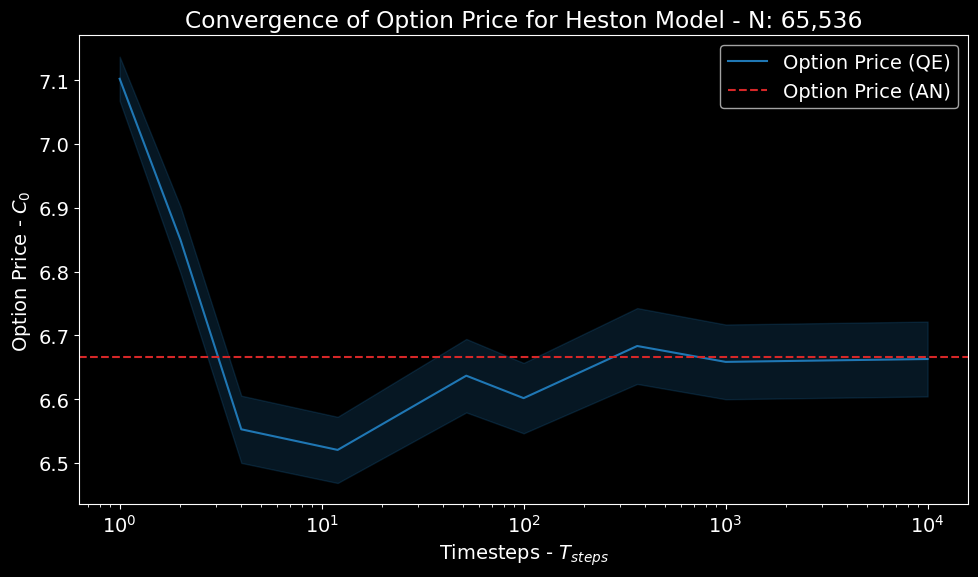

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(T_steps_array, C0s, label='Option Price (QE)', color='tab:blue')
plt.fill_between(T_steps_array, C0s - SEs, C0s + SEs, alpha=0.2, color='tab:blue')
plt.axhline(C0_Analytical, color='tab:red', linestyle='dashed', label='Option Price (AN)')
plt.xlabel(r'Timesteps - $T_{steps}$') ; plt.ylabel(r'Option Price - $C_0$')
plt.title(f'Convergence of Option Price for Heston Model - N: {N_paths:,}')
plt.xscale('log')
plt.legend() ; plt.tight_layout() ; plt.show()

# Heston Model Analysis

This repository contains code and data for analyzing the Heston model using various methods for pricing options and calculating implied volatility. The analysis includes bootstrapping implied volatilities and comparing different methods such as Quadratic Exponential (QE) and Empirical Moments (EM).

## Repository Structure

- **Heston Model Quadratic Exponential.ipynb**: Jupyter Notebook containing the main analysis code for the Heston model.
- **Moments: QE Heston.csv**: CSV file containing moments data for the Quadratic Exponential method.
- **Moments: Simple Heston.csv**: CSV file containing moments data for the Simple Heston method.

## Requirements

- Python 3.x
- Required Python packages:
  - `numpy`
  - `matplotlib`
  - `py_vollib_vectorized`
  - [`tqdm`](command:_github.copilot.openSymbolFromReferences?%5B%7B%22%24mid%22%3A1%2C%22path%22%3A%22%2FUsers%2Falexanderithakis%2F.vscode%2Fextensions%2Fms-python.vscode-pylance-2024.7.1%2Fdist%2Ftypeshed-fallback%2Fstubs%2Ftqdm%2Ftqdm%2Fstd.pyi%22%2C%22scheme%22%3A%22file%22%7D%2C%7B%22line%22%3A33%2C%22character%22%3A6%7D%5D "../../../.vscode/extensions/ms-python.vscode-pylance-2024.7.1/dist/typeshed-fallback/stubs/tqdm/tqdm/std.pyi")

You can install the required packages using pip:


In [ ]:
pip install numpy matplotlib py_vollib_vectorized tqdm



## Usage

1. **Bootstrap Implied Volatility**:
   The `Bootstrap_IV` function in the notebook performs bootstrapping to calculate implied volatilities. It takes an array of terminal stock prices and returns the mean, standard error, and confidence intervals for the implied volatilities.

2. **Plotting Implied Volatility**:
   The notebook includes code to plot the implied volatilities for different methods (QE, EM, Analytical). The plots show the mean implied volatility along with confidence intervals.

3. **Moments Data**:
   The CSV files contain moments data for the QE and Simple Heston methods. These files include analytical and empirical values for various moments, along with confidence intervals and differences.

## Example

To run the analysis, open the `Heston Model Quadratic Exponential.ipynb` notebook in Jupyter and execute the cells. The notebook will generate plots showing the implied volatilities for different methods.

## License

This project is licensed under the MIT License. See the [LICENSE](LICENSE) file for details.

## Acknowledgements

- The `py_vollib_vectorized` library is used for calculating implied volatilities.
- The analysis is based on the Heston model for option pricing.

For any questions or issues, please open an issue in the repository.